# X-TEC analysis of Sr$_3$Rh$_4$Sn$_{13}$ XRD data

Here we analyse the XRD data of Sr$_3$Rh$_4$Sn$_{13}$, a quasi-skutterudite family which shows charge density wave ordering  below a quantum critical point.

## Import Libraries

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt 

import time
import sys
sys.path.append('path to local directory/XTEC_codes/') # set this to the local directory containing XTEC code

%load_ext autoreload
%autoreload 2



## Import the XRD Data

The data loading can be customized to the type of file and structure of data stored. 

Ultimately, one requires a temperature series of  intensity  at (Qh, Qk, Ql) points of the 3D reciprocal lattice (or equivalently in 2D reciprocal lattice) as an array with shape = (num_Temperature, num_Ql, num_Qk, num_Qh) for 3D data, or (num_Temperature, num_Qk, num_Qh) for 2D data.

The exact values of Qh, Qk and Ql would aid in plots to identify the location of pixels in reciprocal space, but otherwise they are not needed for the clustering analysis.


For this example, we use a small 2D slice: (H,K,0) of of a large volume XRD data collected for different temperatures at the Advanced Photon Source. The data is stored as a pickled file. 


In [2]:
import pickle
obj = pickle.load(open("Raw_data.p", "rb"))
I=obj['Data']                            # this is the raw intensity of (H, K) at various temperatures                 
Tlist=obj['Temp']   
Qh=obj['Qh']       
Qk=obj['Qk']      


print('(num_T, num_h, num_k)=',I.shape)   # (num_T, num_k, num_h)
print('Temperatures (K)=',Tlist)
print('L = 0')
print('Qk =', Qk[0],' to ',np.round(Qk[-1],4), ' r.l.u. per pixel=',np.round(Qk[1]-Qk[0],4))
print('Qh =', Qh[0],' to ',np.round(Qh[-1],4), ' r.l.u. per pixel=',np.round(Qh[1]-Qh[0],4))

(num_T, num_h, num_k)= (24, 600, 600)
Temperatures (K)= [ 30  50  70  90 100 110 120 122 124 126 128 130 132 134 136 138 140 145
 150 160 170 180 200 220]
L = 0
Qk = -15.0  to  14.95  r.l.u. per pixel= 0.05
Qh = -15.0  to  14.95  r.l.u. per pixel= 0.05


### Plotting a section of the the raw data to see the CDW  peaks at low temperatures 

Text(0.5, 1.0, 'T=220K')

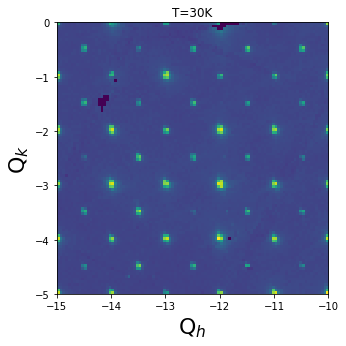

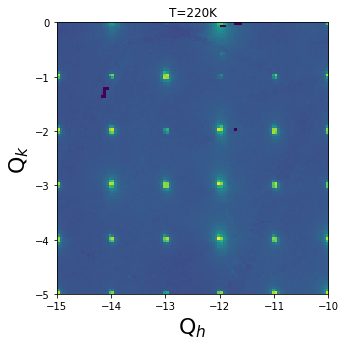

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(1+I[0][200:300,0:100]),origin="lower",extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=22)
plt.ylabel("Q$_k$",size=22)
plt.title('T='+ str(Tlist[0])+'K')

plt.figure(figsize=(5,5))
plt.imshow(np.log(1+I[-1][200:300,0:100]),origin="lower",extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=22)
plt.ylabel("Q$_k$",size=22)
plt.title('T='+ str(Tlist[-1])+'K')


# X-TEC analysis

#### 1. The data is first put through a two-stage preprocessing to remove noise and reduce the volume and the dynamic range of the intensity scale: 

    1.1. Thresholding the low intensity background noise. 

    1.2. Rescaling intensities to reduce dynamic range, and retain only those rescaled intensities 
    that show high variance in temperature. 

#### 2. Then the preprocessed data is clustered with Gaussian Mixture Model (GMM) to identify distinct temperature trajectories of the intensities $I(T,h,k)$. 

    2.1 We show simple GMM clustering, where each (h,k) point is clustered independently, ignoring the 
    correlations between different reciprocal space points.

    2.2 More sensible results can be obtained when correlations are introduced among nearby momenta, since experiments         are resolution limited and intensity peaks in reciprocal space are broadened by fluctuations and noise (local smoothness). We also expect periodic zone-to-zone correlations (periodic smoothness). These correlations are incorporated through label smoothing.

## 1.1 Thresholding low intensity background

Remove low intensity background noise. Assumes that the peaks/relevant
x-ray features are sparse so that most momenta have predominantely background intensity contributions.

Cutoff estimated by minimizing the Kullback-Leibler (KL) distance between the distribution of $\log[\overline{I_q(T)}]$ and a Gaussian distribution with (high intensity) cutoff. See supplementary materials of  Venderley et al., https://arxiv.org/abs/2008.03275.  
 
See preprocessing.py for comments on the code 

In [4]:
# First remove zero intensity points from the data
from Preprocessing import Mask_Zeros             

masked    = Mask_Zeros(I,'zero_mean') # removes data with zero intensity. 
#Try 'zero mean' to remove points with I=0 for all T (mean_T=0), or 'any zeros': to remove points where I=0 at any T 

In [5]:
from Preprocessing import Threshold_Background    # for thresholding background intensity

threshold = Threshold_Background(masked)  
# default values for other arguments: bin_size=None, threshold_type='KL', max_iter=100 

# the results from thresholding are stored as
#    threshold.data_thresholded : thresholded data, shape=(num_T, num_thresholded_data)
#    threshold.ind_thresholded  : hkl indices of the thresholded data, shape=(num_data_thresholded, 3 or 2)
#    threshold.thresholded      : 0/1 on whether the corresponding pixel is thresholded. shape=(num_l, num_k,...)

data_post_thresh = threshold.data_thresholded  # shape=(num_temperatures, num_thresholded data)
print('num of original non zero data=', np.prod(threshold.data_shape_orig[1:])) 
print('num of thresholded data=', data_post_thresh.shape[1])

num of original non zero data= 360000
num of thresholded data= 34565


Let us see the thresholding results.

Below is the $\log[\overline{I_q(T)}]$ distribution and the Gaussian fit with high intensity cutoff estimated from minimising KL distance.

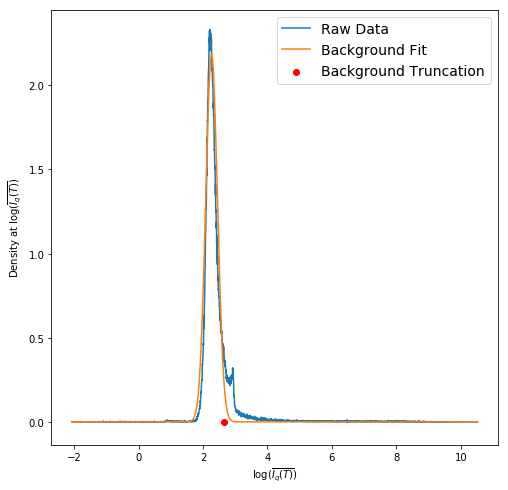

In [12]:
figsize_=(8,8)
threshold.plot_cutoff(figsize_)

Note the non Gaussian features in the distribution just above the cutoff intensity (red dot). Those are the useful data we are after.

All data points that have $\log[\overline{I_q(T)}]$ above estimated cutoff are retained. The plot below shows those remaining points in the hk plane as grey clusters  

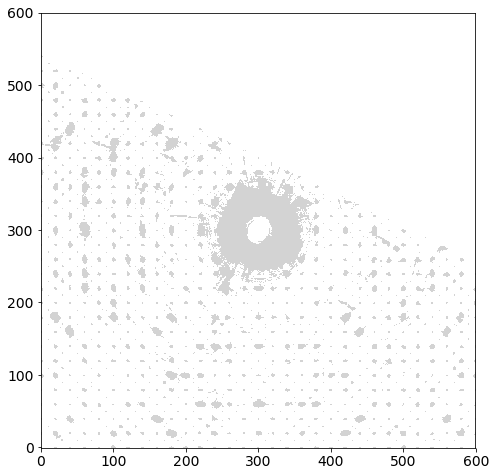

In [8]:
plot=threshold.plot_thresholding_2D_slice(figsize_)  
# threshold.plot_thresholding_2D_slice(figsize_, slice_ind_, axis_) : plots the 2D image 
# with points whose intensity distribution is above the cutoff marked as grey. 
# if data is 3D, then set the slice ind and axis_ (default=None) to select the index of the 2D slice along axis_ =0,1 or 2.
 


 Plot the temperature trajectory of intensitities that pass thresholding. 

(0, 10000)

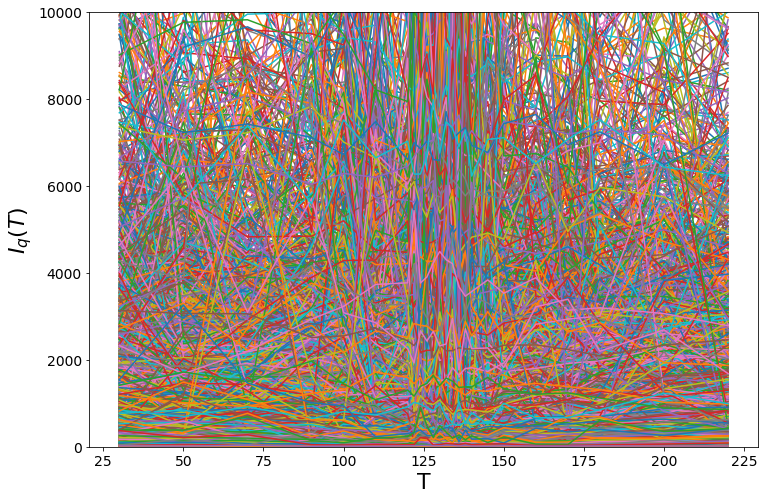

In [9]:
plt.figure(figsize=(12,8))
plt.plot(Tlist,data_post_thresh);
plt.xlabel('T',size=22)
plt.ylabel('$I_q(T)$',size=22)
plt.ylim((0,10000))

Notice the large range of intensities. The smooth order parameter like behavior of the CDW intensities are burried inside this large mess.

## 1.2 Rescale intensity and isolate high variance trajectories

To reduce the large range in the scale of intensities, we rescale intensities $I_q(T)$ by subtracting and dividing their mean over temperature $\overline {I_q(T)}$ for each $q$: 

$ \tilde{I}_q(T)=\dfrac{I_q(T)}{\overline {I_q(T)}}-1$ 

Some other rescaling schemes can also be applied, like subtracting the mean (over T) and dividing by variance (over T). Using $\log(I)$ instead can also be useful. 

Sometimes it is useful to remove intensities whose temperature trajectories show low variance

In [6]:
# get rescaled intensity by subtracting and dividing by the mean over T: 

Rescaled_data_no_mean=data_post_thresh/np.mean(data_post_thresh,axis=0)-1 


threshold.Get_High_Variance(Rescaled_data_no_mean,0.5)


#  threshold.Get_High_Variance(Rescaled_data_no_mean,std_dev_cutoff) : get data whose std dev (in temp)>std_dev_cutoff
# The high variance results are:
#    threshold.data_high_std_dev : high variance trajectories, shape=(num_T, num_data_high_std_dev)
#    threshold.ind_high_std_dev  : hkl indices of high std trajectories, shape=(num_data_high_std_dev,3 or 2) 
#    threshold.data_low_std_dev  : low variance trajectories, shape=(num_T, num_data_low_std_dev)
#    threshold.ind_low_std_dev   :  hkl indices of low var trajectories, shape=(num_data_low_std_dev,3 or 2)

print('num of High variance data =', np.prod(threshold.data_high_std_dev.shape[1:]))
print('num of Low variance data=', np.prod(threshold.data_low_std_dev.shape[1:]))


num of High variance data = 3561
num of Low variance data= 31004


Text(0, 0.5, 'Rescaled $\\widetilde{I}_q(T)$')

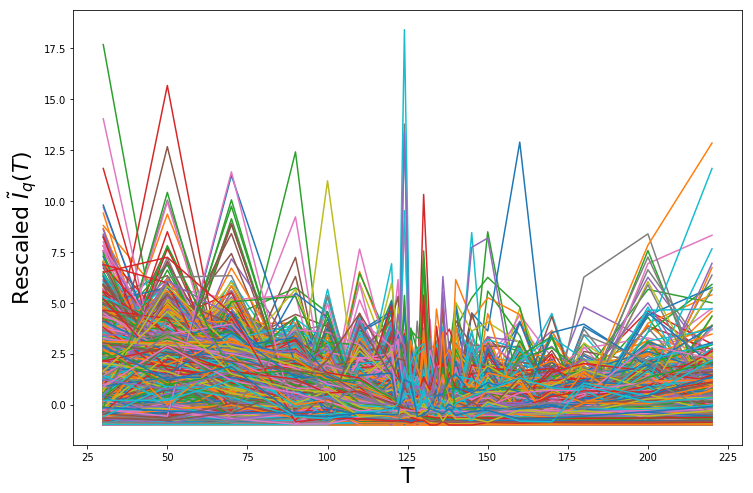

In [9]:
# plot the high variance trajectories
plt.figure(figsize=(12,8))
plt.plot(Tlist,threshold.data_high_std_dev);
plt.xlabel('T',size=22)
plt.ylabel('Rescaled $\widetilde{I}_q(T)$',size=22)

## 2 GMM clustering

Use GMM algorithm to cluster the preprocessed data (high std dev data). 

See GMM.py for details. The code uses Step-wise Expectation Maximization algorithm  (cf. Liang and Klein 2009) to cluster data. 

In [11]:
from GMM import GMM                               # for GMM clustering

### 2.1 vanilla GMM 
We first apply simple GMM clustering. Here temperature series of intensity at each $q$ point is clustered independently.  

In [12]:
Temp            = np.array(Tlist)                              # temperature list
Data_for_GMM    = threshold.data_high_std_dev.transpose()      # data should be arranged as (num_data,num_T) for GMM


num_clusters = 2                                # change this to 2,3 4 etc and see. 
# optimal num of clusters can be estimated once adding more clusters give similar looking trajectories.


# see GMM.py for details on the GMM() and RunEM(). The 
clusterGMM = GMM(Data_for_GMM,num_clusters) # sets the parameters and the data for GMM clustering
clusterGMM.RunEM()                          # performs the simple (no label smoothing) EM algorithm to cluster trajectories
print('num of trajectories in each cluster:', clusterGMM.num_per_cluster)


# Here, default values are set for other (somewhat technical) parameters of GMM. Default values work well in most cases.

# The full arguments of GMM are:
# clusterGMM= GMM(Data_for_GMM, num_clusters, cov_type = "diagonal", batch_num = 1, alpha = 0.7, tol = 1e-5, max_batch_epoch = 50, max_full_epoch = 500,verbose = False)
#
# cov_type        : = "diagonal" or "full", whether to keep only diagonal elements or retain full cov matrix. 
# batch_num       : number of batches. Algorithm has a "batch" phase, followed by a "full" phase that operates on the entire dataset.
# alpha           : decay exponent of i'th step-size- eta_i = (i + 2 )^{- alpha}, 0.5 < alpha < 1.
# tol             : tolerance for the convergence of loglikelihood.
# max_batch_epoch : max number of batch iterations.
# max_full_epoch  : max number of iterations on full dataset.
# verbose         : True/False on whether to print loglikelihood at each iteration.

# Try tweaking these other parameters in case default values do not converge to a stable clustering 

num of trajectories in each cluster: [1820, 1741]


Let us plot the clustering results.

First, let us plot the rescaled trajectories $\tilde{I}_q(T)$, with each trajectory colored either red (if belonging to cluster group 0) or blue (if belonging to cluster group 1). 

Text(0.5, 1.0, ' ')

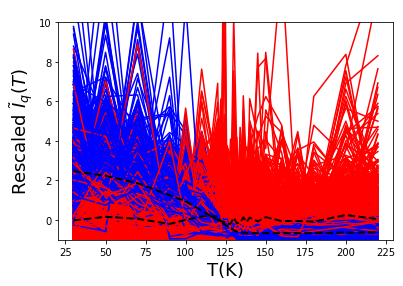

In [17]:
p1=clusterGMM.Plot_Cluster_Results_traj(Temp,traj_flag=True) 
# we set traj_flag = True to plot the rescaled intensities with their colors. 
# The mean trajectory of the clusters will be shown as dashed black lines 

p1.xlabel('T(K)', size=18)
p1.ylabel('Rescaled $\widetilde{I}_q(T)$', size=18)
p1.ylim([-1,10])
p1.title(' ')



#   clusterGMM.Plot_Cluster_Results_traj(x_train, traj_flag,data_means):  (see GMM.py)
#       Plots the trajectories and cluster means +- 1*variance.  
#       x_train    : Temperatures, dim=(num_T)
#       traj_flag  : if True plots the trajectories  color coded by the clustering label.
#                  : if False, plots the mean trajectory, and shades 1 std dev corresponding to each cluster.  
#       data_means : if not None, will shift the cluster_means. data_means, dim=(num_data), gives 
#                     the value each traj needs to be offset.  Useful when to put back actual data mean, 
#                      which might have been subtracted during rescaling.   

#       Plotting for only less than 7 clusters currently enabled.  


Now, let us plot the mean trajectory with 1 standard deviation shaded, for the two clusters (red and blue). The order parameter like behavior of the CDW intensities are apparent from here, with a transition temperature $T_c\approx 130 K$    

Text(0, 0.5, 'Rescaled $\\widetilde{I}_q(T)$')

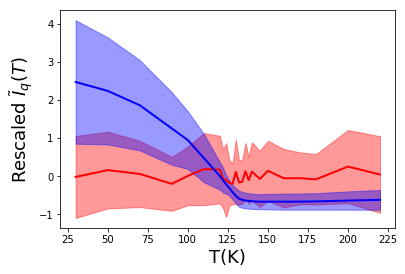

In [25]:
p2=clusterGMM.Plot_Cluster_Results_traj(Temp,traj_flag=False)
p2.xlabel('T(K)',size=18)
p2.ylabel('Rescaled $\widetilde{I}_q(T)$', size=18)


Let us plot and see which points in the $(h,k)$ plane belong to the red/blue cluster.   

Text(0.5, 1.0, 'Q$_l$=0')

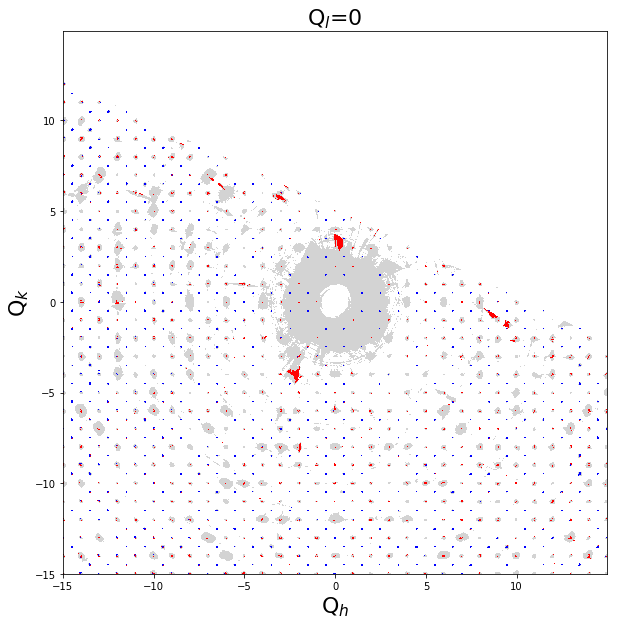

In [31]:
Data_ind=threshold.ind_high_std_dev   # shape=(num_high_std_dev_data,2),give the (h,k) indices of the data 
clusterGMM.Plot_Cluster_kspace_2D_slice(threshold,None,None,Data_ind) 

plt.figure(figsize=(10,10))
plt.imshow(clusterGMM.plot_image,origin='lower',cmap=clusterGMM.plot_cmap,norm=clusterGMM.plot_norm,extent=[Qk[0], Qk[-1], Qh[0], Qh[-1]])
plt.xlabel("Q$_h$",size=22)
plt.ylabel("Q$_k$",size=22)
plt.title('Q$_l$=0',size=22)




#   clusterGMM.Plot_Cluster_kspace_2D_slice(threshold,figsize_,cluster_list,data_ind,slice_ind,axis_) :Plots the 2D image slice, with each (thresholded)
#   pixel color coded by the clustering label, or colored grey if not clustered. 
#   the input parameters are:
#       threshold      : class Threshold_Background from Preprocessing
#       figsize_       : size of image. If None, will not plot the image
#       cluster_list   : list of cluster numbers 0,1,2 etc. to be plotted. The remaining clusters if any will show as grey.
#                        if None, all clusters will be plotted.
#       data_ind       : (h,k,l) or (h,k) indices of the clustered data. shape=(num_data,2) or (num_data,3)
#       slice_ind      : if 3D, the index along which to take the data slice, plotting_matrix.take(slice_ind, axis=axis_)
#       axis_          : axis_ of slice_ind, if data is 3D 
   
#   Output attributes for ploting with imshow(),
#       clusterGMM.plot_image : 2D image to be plotted 
#       clusterGMM.plot_cmap  : color map for the clustering, matching the same color scheme of the cluster trajectories
#       clusterGMM.plot_norm  : the norm to be used in imshow() so that cmap matches the cluster assignment integers 



Text(0.5, 1.0, 'Q$_l$=0')

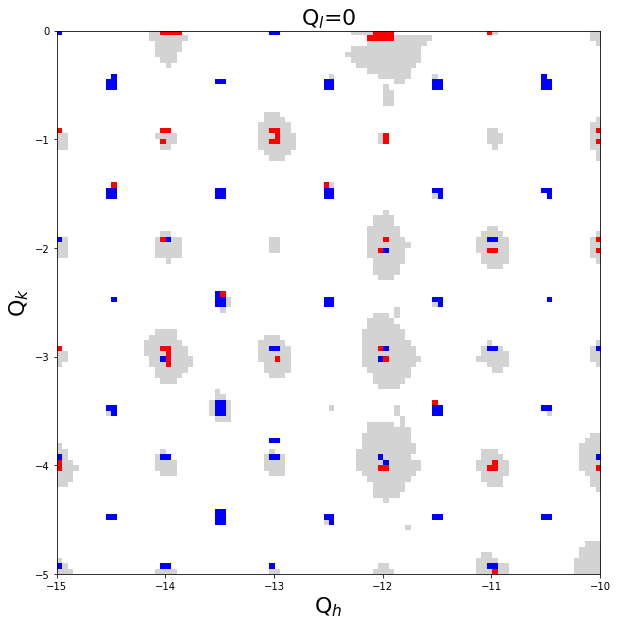

In [30]:
# a zoom in image of the above figure..

plt.figure(figsize=(10,10))
plt.imshow(clusterGMM.plot_image[200:300,0:100],origin='lower',cmap=clusterGMM.plot_cmap,norm=clusterGMM.plot_norm,extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=22)
plt.ylabel("Q$_k$",size=22)
plt.title('Q$_l$=0',size=22)



Notice that CDW peaks have overwhelmingly same color matching the order parameter like trajectory.

However, there are some nearby pixels assigned to different colors, when we expect them to correspond to same cluster. This is the consequence of neglecting correlations between neighboring points, and between different unit cells. These correlations are accounted in the label smoothing procedure, shown below.

### 2.2 GMM with label smoothing

Label smoothing incorporates correlations between neighboring pixels and across unit cells by allowing labels to diffuse between neighboring points and between unit cells. To implement this label diffusion, we should construct a weighted graph (adjacency matrix or Markov_Matrix) connecting similar momenta. This is implemented by Build_Markov_matrix in GMM_kernels.py.

Label smoothing is performed by introducing Markov_Matrix between E and M step to diffuse cluster probabilities with neighbouring data.


See GMM_kernels.py for details on the code, and supplementary materials of Venderley et al, https://arxiv.org/abs/2008.03275.


#### Build Markov matrix

In [32]:
from GMM_kernels import *                               # for generating Markov matrix for label smoothing

In [43]:
data_inds = threshold.ind_high_std_dev
unit_cell_shape = np.array([20,20])
L_scale = .2               # change L_scale to control the length scale for smoothing the labels
kernel_type = 'periodic'
uniform_similarity = True
Markov_matrix = Build_Markov_Matrix(data_inds, L_scale,kernel_type,unit_cell_shape,uniform_similarity)




# The parameters of Build_Markov_Matrix are:
#        data_inds (num_data,dim): contain the  hkl indices (dim=3 or dim=2) of the preprocessed data
#        L_scale: lengthscale for local correlations
#        Kernel_type= 'local' / 'periodic' : indicating whether correlations are local, 
#                      or periodic (with unit_cell_shape) 
#        unit_cell_shape: an array that gives the size of unit cell (integer lengths in unit of number of pixels)
#                          (only needed for periodic kernel)
#        uniform_similarity= True/False: if True, sets all nonzero elements of Markov matrix (above zero_cutoff) to 1 (with 
#                                     a normalization factor)
#        zero_cutoff =1e-2 sets the cutoff to select nonzero elements of Markov matrix
        
        



	Building Adjacency Matrix, 1cpu, ...
	Finished Building Adjacency Matrix in 3.5368192195892334 s 



#### Run EM with label smoothing

In [40]:
x_train = Tlist
y_train = threshold.data_high_std_dev.transpose()


num_clusters = 2
Smooth_clusterGMM = GMM(y_train,num_clusters)
smoothing_iterations=1      # number of times Markov matrix is introduced between E and M step
Smooth_clusterGMM.RunEM(True, Markov_matrix,smoothing_iterations)   # RunEM with Markov matrix 

print('num of trajectories in each cluster:', Smooth_clusterGMM.num_per_cluster)


num of trajectories in each cluster: [1954, 1607]


Text(0.5, 1.0, 'GMM with label smoothing')

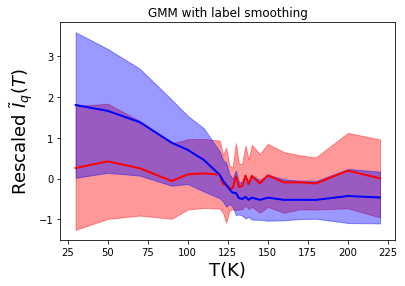

In [42]:
# plot cluster mean trajectories and their variance
p2=Smooth_clusterGMM.Plot_Cluster_Results_traj(Temp,traj_flag=False)
p2.xlabel('T(K)',size=18)
p2.ylabel('Rescaled $\widetilde{I}_q(T)$', size=18)
p2.title('GMM with label smoothing')

Let us plot the clustering assignments to see if $(h,k)$ points have smooth labels   

Text(0.5, 1.0, 'Q$_l$=0, GMM with label smoothing')

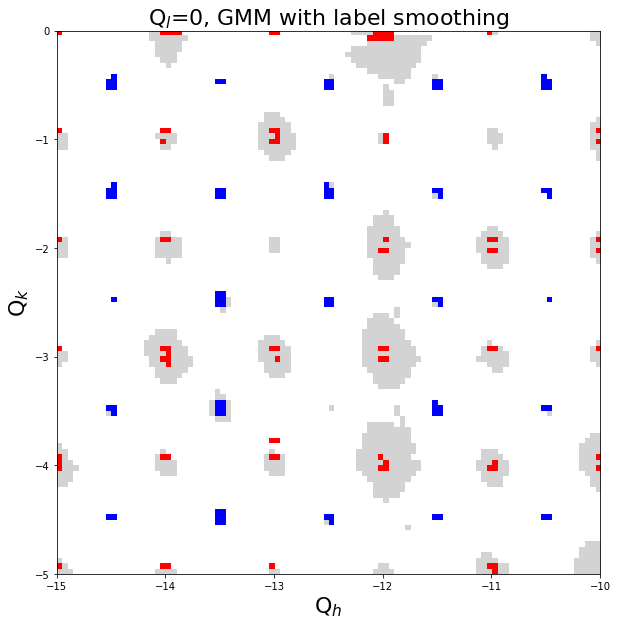

In [52]:
Data_ind=threshold.ind_high_std_dev
Smooth_clusterGMM.Plot_Cluster_kspace_2D_slice(threshold,None,None,Data_ind)

plt.figure(figsize=(10,10))
plt.imshow(Smooth_clusterGMM.plot_image[200:300,0:100],origin='lower',cmap=Smooth_clusterGMM.plot_cmap,norm=Smooth_clusterGMM.plot_norm,extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=22)
plt.ylabel("Q$_k$",size=22)
plt.title('Q$_l$=0, GMM with label smoothing',size=22)


Now, we have same labels (colors) for neighboring points. All CDW peaks have one color, matching that of the order parameter trajectory, while Bragg peaks have the other color. 